In [33]:
import numpy as np
from math import*
import pickle
import matplotlib.pyplot as plt
import control.matlab as cm


In [34]:
# Filename:  cit2s.m

# Calculation of state matrix and input matrix for calculation
# of symmetric aircraft response to atmospheric turbulence.
# The system model is in the form

#       .
#       x = Ax + Bu
#       -    -    -

# with
#     x = [u/V alpha theta qc/V u_g/V alpha_g alpha_g*]'
# and
#     u = [delta_e w_1 w_3]'.

# The turbulence filters are according to Dryden.

# Cessna Citation Ce-500, landing (1)

# Checked MM June 2021 - Python version by B. Englebert (July 2021)

# INPUT TURBULENCE- AND AIRCRAFT PARAMETERS




V = 189.6
m = 5445
twmuc = 2*147
KY2 = 0.950
c = 2.022
S = 24.2
lh = 5.5

xcg = 0.3 * c
W = 53361
b = 13.36
h = 6096
rho = 0.6528
mub = 22
muc = 157
KX2 = 0.013
KZ2 = 0.037
KXZ = 0.002

# TURBULENCE PARAMETERS
sigma = 2
Lg = 150
sigmaug_V = sigma/V
sigmaag = sigma/V

# AIRCRAFT SYMMETRIC AERODYNAMIC DERIVATIVES :
CX0 = 0.0000
CZ0 = -0.1620
Cm0 = 0.0000
CXu = -0.0600
CZu = -0.3240
Cmu = 0.0000
CXa = 0.0545
CZa = -5.8000
Cma = -0.5350
CXq = 0.0000
CZq = -4.3800
Cmq = -8.0000
CXd = 0.0000
CZd = -0.5798
Cmd = -1.4440
CXfa = 0.0000
CZfa = -1.8300
Cmfa = -4.7500
CZfug = 0.0000
Cmfug = -Cm0*lh/c
CZfag = CZfa-CZq
Cmfag = Cmfa-Cmq

# CALCULATION OF AIRCRAFT SYMMETRIC STABILITY DERIVATIVES
xu = (V/c)*(CXu/twmuc)
xa = (V/c)*(CXa/twmuc)
xt = (V/c)*(CZ0/twmuc)
xq = 0
xd = (V/c)*(CXd/twmuc)
xug = xu
xfug = 0
xag = xa
xfag = 0

zu = (V/c)*(CZu/(twmuc-CZfa))
za = (V/c)*(CZa/(twmuc-CZfa))
zt = (V/c)*(-CX0/(twmuc-CZfa))
zq = (V/c)*((CZq+twmuc)/(twmuc-CZfa))
zd = (V/c)*(CZd/(twmuc-CZfa))
zug = zu
zfug = (V/c)*(CZfug/(twmuc-CZfa))
zag = za
zfag = (V/c)*(CZfag/(twmuc-CZfa))

mu = (V/c)*((Cmu+CZu*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
ma = (V/c)*((Cma+CZa*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mt = (V/c)*((-CX0*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mq = (V/c)*(Cmq+Cmfa*(twmuc+CZq)/(twmuc-CZfa))/(twmuc*KY2)
md = (V/c)*((Cmd+CZd*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mug = mu
mfug = (V/c)*(Cmfug+CZfug*Cmfa/(twmuc-CZfa))/(twmuc*KY2)
mag = ma
mfag = (V/c)*(Cmfag+CZfag*Cmfa/(twmuc-CZfa))/(twmuc*KY2)

# STATE- AND INPUT MATRICES
A = np.mat([[xu, xa, xt, 0,    xug,                  xag,       0],
            [zu, za, zt, zq,   zug-zfug*V/Lg *
                (c/V),  zag,       zfag*(c/V)],
            [0,  0,  0,  V/c,  0,                    0,         0],
            [mu, ma, mt, mq,   mug-mfug*V/Lg *
                (c/V),  mag,       mfag*(c/V)],
            [0,  0,  0,  0,   -V/Lg,                 0,         0],
            [0,  0,  0,  0,    0,                    0,         1],
            [0,  0,  0,  0,    0,                   -(V/Lg)**2, -2*V/Lg]])

B = np.mat([[xd, 0,                                 0],
            [zd, zfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            zfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 0],
            [md, mfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            mfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  sigmaug_V*sqrt(2*V/Lg),            0],
            [0,  0,
                sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 (1-2*sqrt(3))*sigmaag*sqrt((V/Lg)**3)]])

C = np.eye(A.shape[0])
D = np.zeros(B.shape)


# # GAIN FACTORS FOR AUTOPILOT CHAPTER 7 AND DEFINITION OF MATRIX At
# # (approximately "Dead Beat" damping)
# Kt = -0.21
# Kq = -3      # gains on "theta" and "q"
# K = np.array([0, 0, Kt, Kq, 0, 0, 0])  # feedback matrix
# At = A-B[:, 0]*K         # new A matrix = (A - BK) because of feedback


1. Stability Analysis


In [35]:
Ar = np.delete(np.delete(A, [0, 2], axis=0), [0, 2], axis=1)
Br = np.delete(B, [0, 2], axis=0)
Cr = np.delete(np.delete(C, [0, 2], axis=0), [0, 2], axis=1)
Dr = np.delete(D, [0, 2], axis=0)


In [36]:
print(Ar.shape)
print(Br.shape)
print(Cr.shape)
print(Dr.shape)

(5, 5)
(5, 3)
(5, 5)
(5, 3)


In [37]:
sys = cm.ss(A, B, C, D)
sysr = cm.ss(Ar, Br, Cr, Dr)

In [38]:
# damping ratio and natural frequency
cm.damp(sys)
cm.damp(sysr)


_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6574      4.629
    -3.043    -3.488j     0.6574      4.629
 -0.009285  +0.06391j     0.1438    0.06458
 -0.009285  -0.06391j     0.1438    0.06458
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264
_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6573      4.629
    -3.043    -3.488j     0.6573      4.629
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264


(array([4.62884742, 4.62884742, 1.264     , 1.264     , 1.264     ]),
 array([0.65734029, 0.65734029, 1.        , 1.        , 1.        ]),
 array([-3.04272792+3.48827109j, -3.04272792-3.48827109j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]))

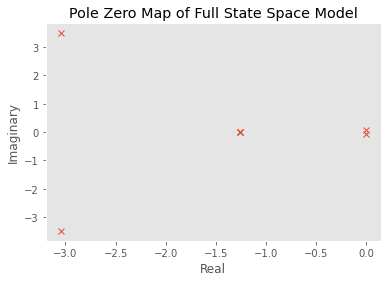

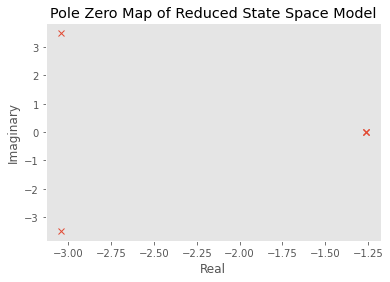

In [39]:

# elevator step response
# yout, T = cm.step(systr, T=np.linspace(0, 10, 2000),  input=0)

# # plot step response of 2nd state
# plt.figure(2)
# plt.plot(T, yout[:, 1] * 180 / np.pi)
# plt.title('Elevator Step Response')
# plt.xlabel('Time [s]')
# plt.ylabel('alpha [deg]')
# plt.grid()
# plt.show()

# plt.figure(3)
# plt.plot(T, yout[:, 3] * 180 / np.pi)
# plt.title('Elevator Step Response')
# plt.xlabel('Time [s]')
# plt.ylabel('qc/V [deg]')
# plt.grid()
# plt.show()

eigA = np.linalg.eigvals(A)
eigAr = np.linalg.eigvals(Ar)

# plot eigenvalues of A matrix
plt.figure(0)
plt.plot(np.real(eigA), np.imag(eigA), 'x')
plt.title('Pole Zero Map of Full State Space Model')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()
# plot eigenvalues of Ar matrix
plt.figure(1)
plt.plot(np.real(eigAr), np.imag(eigAr), 'x')
plt.title('Pole Zero Map of Reduced State Space Model')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()


2. Time-Domain Analysis

In [40]:
sys = cm.ss(A, B, C, D)
sysr = cm.ss(Ar, Br, Cr, Dr)

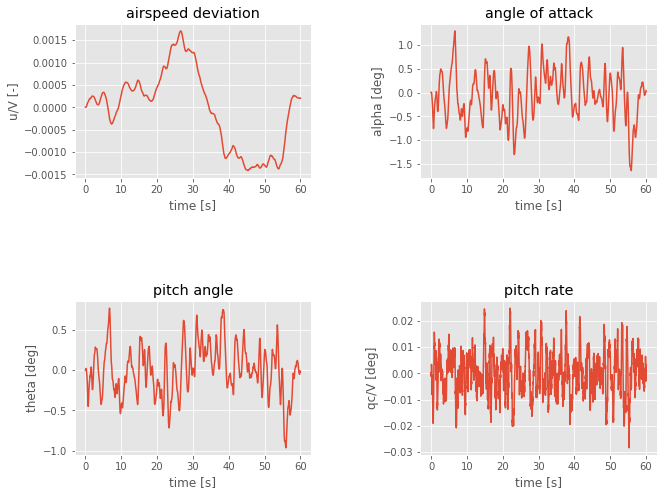

In [41]:

# TIME AXIS INPUT VECTOR DEFINITION
dt = 0.01
T = 60
t = np.arange(0, T + dt, dt)
N = len(t)

# N rows and 1 column
# randn is normal distribution
# INPUT VECTOR DEFINITION
nn = np.zeros((N, 1))                    # zero input elevator
w1 = np.random.randn(N, 1)/sqrt(dt)      # scaled input hor. turbulence,
# note the sqrt(dt) because of lsim
w3 = np.random.randn(N, 1)/sqrt(dt)      # scaled input vert. turbulence,
# note the sqrt(dt) because of lsim
u = np.hstack((nn, nn, w3))             # input vector definition (vertical
# turbulence only, can be changed).
y = cm.lsim(sys, u, t)[0]


# 2x2 plot for t vs y[:, 0] and t vs y[:, 1], etc.
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(t, y[:, 0])
plt.xlabel('time [s]')
plt.ylabel('u/V [-]')
plt.title('airspeed deviation')

plt.subplot(2, 2, 2)
plt.plot(t, y[:, 1]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('alpha [deg]')
plt.title('angle of attack')

plt.subplot(2, 2, 3)
plt.plot(t, y[:, 2]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('theta [deg]')
plt.title('pitch angle')

plt.subplot(2, 2, 4)
plt.plot(t, y[:, 3]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('qc/V [deg]')
plt.title('pitch rate')
# space out the plots
plt.tight_layout()
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# make the plots more fancy
plt.style.use('ggplot')
plt.savefig('figures/states_vs_t.pdf')
plt.show()


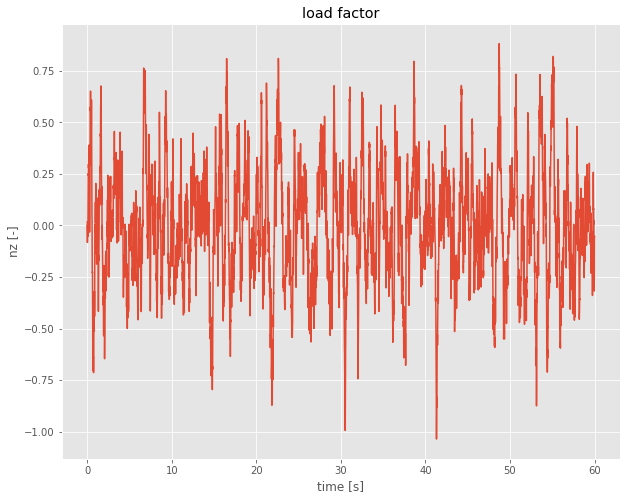

In [42]:
# az = V * (y[:, 2] - y[:, 1])  # V * flight path angle dot
# nz = az / 9.81                   # normal load factor

g = 9.81
qcV = y[:, 3]
alpha = y[:, 1]
alphanz = alpha
alphanz = np.hstack((alphanz, np.array([0])))

nz = (V/g)*((V/c)*qcV-np.diff(alphanz)/dt)
nz[-1] = nz[-2]

# plot nz vs t
plt.figure()
plt.plot(t, nz)
plt.xlabel('time [s]')
plt.ylabel('nz [-]')
plt.title('load factor')
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
plt.savefig('figures/nz_vs_t.pdf')


3. Spectral Analysis


i) analytical PSD using ss representation


In [43]:
# DEFINE MISCELLANEOUS
g  = 9.81                     # gravitational acc [N/kg]

# calculation of the frequency response of the normal acceleration factor
# horizontal turbulence : u=2, vertical turbulence u=3.

# FREQUENCY AXIS
Nomega = 300
w = np.logspace(-2,2,Nomega)

# C and D MATRICES AND SYSTEMS
D0 = np.zeros((1, 3))

Cu = np.array([1, 0, 0, 0, 0, 0, 0])
sysu = cm.ss(A, B[:,1], Cu, D0[:, 1])
sysu2 = cm.ss(A, B[:,2], Cu, D0[:, 2])

Calpha = np.array([0, 1, 0, 0, 0, 0, 0])
sysalpha = cm.ss(A, B[:,1], Calpha, D0[:, 1])
sysalpha2 = cm.ss(A, B[:, 2], Calpha, D0[:, 2])


Ctheta = np.array([0, 0, 1, 0, 0, 0, 0])
systheta = cm.ss(A, B[:,1], Ctheta, D0[:, 1])
systheta2 = cm.ss(A, B[:, 2], Ctheta, D0[:, 2])

Cq     = np.array([0, 0, 0, 1, 0, 0, 0])
sysq = cm.ss(A, B[:,1], Cq, D0[:, 1])
sysq2 = cm.ss(A, B[:,2], Cq, D0[:, 2])

Cug    = np.array([0, 0, 0, 0, 1, 0, 0])
sysug = cm.ss(A, B[:,1], Cug, D0[:, 1])
sysug2 = cm.ss(A, B[:,2], Cug, D0[:, 2])

Cag    = np.array([0, 0, 0, 0, 0, 1, 0])
sysag = cm.ss(A, B[:,1], Cag, D0[:, 1])
sysag2 = cm.ss(A, B[:, 2], Cag, D0[:, 2])

Calphadot = A[1,:]
Dalphadot = B[1,:]

#% COMPUTE FREQUENCY RESPONSE FUNCTION AND PSD
mag = cm.bode(sysu, w, plot=False)[0]
mag += cm.bode(sysu2, w, plot=False)[0]
Suu = mag * mag

mag = cm.bode(sysalpha, w, plot=False)[0]
mag += cm.bode(sysalpha2, w, plot=False)[0]
Saa = mag * mag

mag = cm.bode(systheta, w, plot=False)[0]
mag += cm.bode(systheta2, w, plot=False)[0]
Stt = mag * mag

mag = cm.bode(sysq, w, plot=False)[0]
mag += cm.bode(sysq2, w, plot=False)[0]
Sqq = mag * mag

mag = cm.bode(sysug, w, plot=False)[0]
mag += cm.bode(sysug2, w, plot=False)[0]
Sugug = mag * mag

mag = cm.bode(sysag, w, plot=False)[0]
mag += cm.bode(sysag2, w, plot=False)[0]
Sagag = mag * mag

# COMPUTE FREQ. RESPONSE of NZ
mag = 0
for i in range(1, 3):
    sysalphadot = cm.ss(A, B[:,i], Calphadot, Dalphadot[:, i])
    Hadotw = cm.frd(sysalphadot, w).fresp
    Hadotw = np.ndarray.flatten(Hadotw)
    Hqw =  cm.frd(sysq, w).fresp
    Hqw = np.ndarray.flatten(Hqw)

    Hnz   = (V/g)*((V/c)*Hqw - Hadotw)
    mag_i   = abs(np.ndarray.flatten(Hnz)) 
    mag += mag_i
Snznz = mag*mag

Sxx = np.array([Suu, Saa, Stt, Sqq, Snznz]).T


In [44]:
Sxx.shape


(300, 5)

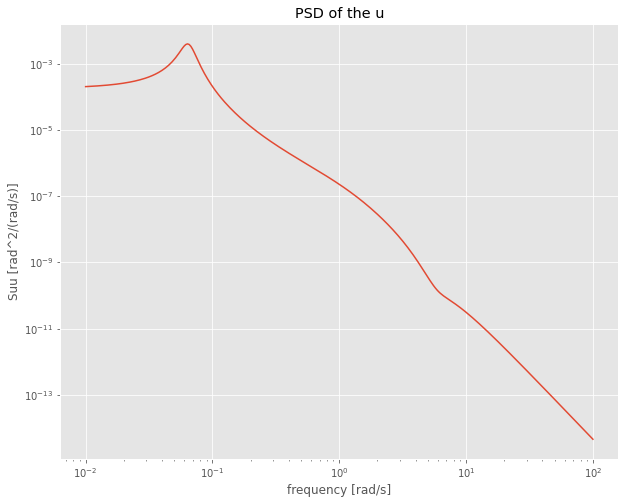

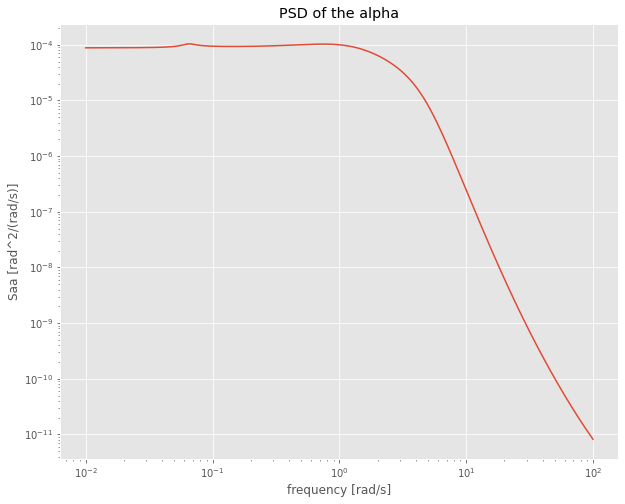

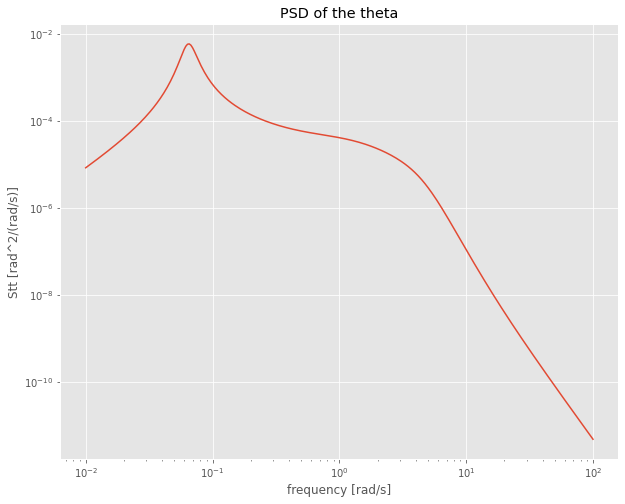

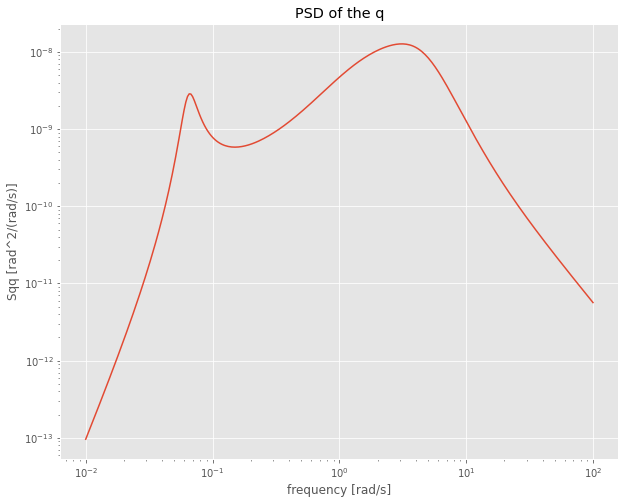

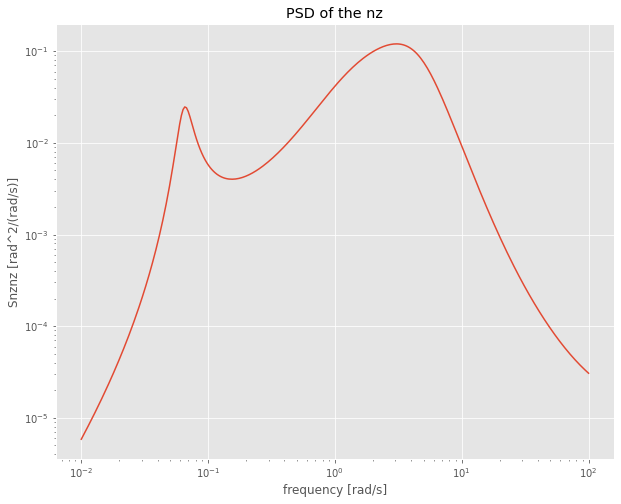

In [45]:
# # plot the PSD
# states = ['u', 'alpha', 'theta', 'q', 'nz']
# S_names = ["Suu", "Saa", "Stt", "Sqq", "Snznz"]
# for i in range(len(states)):
#     plt.figure(i)    
#     # loglog plot
#     plt.loglog(w, Sxx[:, i])
#     plt.xlabel('frequency [rad/s]')
#     plt.ylabel(f'{S_names[i]} [rad^2/(rad/s)]')
#     plt.title(f'PSD of the {states[i]}')
#     # make the plots bigger
#     plt.gcf().set_size_inches(10, 8)
#     # save the plot
#     plt.savefig(f'figures/{S_names[i]}_vs_w.pdf')


ii) experimental PSD using FFT

In [46]:
# DEFINE TIME AXIS
dt = 0.05
fs = 1/dt
T = 200
t = np.arange(0, T + dt, dt)
N = len(t)

# CREATE ZERO INPUT SIGNAL
delta = np.zeros(N)

# CREATE NORMAL WHITE NOISE SIGNALS
#  if Vertical turbulence   (u=3) : w1 = 0
#  if Horizontal turbulence (u=2) : w3 = 0

w1 = np.random.randn(N)/sqrt(dt)   # sqrt(dt) because of lsim
w3 = np.random.randn(N)/sqrt(dt)  # sqrt(dt) because of lsim

inpsig = np.array([delta, w1, w3]).T

# system definition
sys = cm.ss(A, B, C, D)

# COMPUTE TIME RESPONSE
y = cm.lsim(sys, inpsig, t)[0]
print(y.shape)


(4001, 7)


In [50]:


hatu = y[:, 0]
alpha = y[:, 1]
theta = y[:, 2]
qcV = y[:, 3]
hatug = y[:, 4]
alphag = y[:, 5]

# Add a trailing zero for alpha array. Because we use the routine
# diff(w) which fills a vector of length(w)-1 with w(i+1)-w(i) for i=1 to
# length(w).

alphanz = alpha
alphanz = np.hstack((alphanz, np.array([0])))

# Calculation of the normal load factor nz according to:
nz = (V/g)*((V/c)*qcV-np.diff(alphanz)/dt)
nz[-1] = nz[-2]

# FFT ALL SIGNALS
U = dt*np.fft.fft(hatu)
ALPHA = dt*np.fft.fft(alpha)
THETA = dt*np.fft.fft(theta)
QCV = dt*np.fft.fft(qcV)
NZ = dt*np.fft.fft(nz)
Ug = dt*np.fft.fft(hatug)
ALPHAg = dt*np.fft.fft(alphag)

# COMPUTE PSDs
Pu = ((1/T) * U*np.conj(U)).real
Palpha = ((1/T) * ALPHA*np.conj(ALPHA)).real
Ptheta = ((1/T) * THETA*np.conj(THETA)).real
PqcV = ((1/T) * QCV*np.conj(QCV)).real
Pnz = ((1/T) * NZ*np.conj(NZ)).real
Pug = ((1/T) * Ug*np.conj(Ug)).real
Palphag = ((1/T) * ALPHAg*np.conj(ALPHAg)).real

#DEFINE FREQUENCY VECTOR FOR PLOTTING
omega = 2*pi*fs*np.arange(0, int(N/2))/N

P_lst = [Pu, Palpha, Ptheta, PqcV, Pnz]


In [60]:
# smoove the PSDs. P_new = 0.25*P_old + 0.5*P_mid + 0.25*P_new
P_lst_new = []
for P in P_lst:
    P_new = np.zeros_like(P)
    P_new[0] = P[0]
    P_new[-1] = P[-1]
    for i in range(1, len(P)-1):
        P_new[i] = 0.25*P[i-1] + 0.5*P[i] + 0.25*P[i+1]
    P_lst_new.append(P_new)

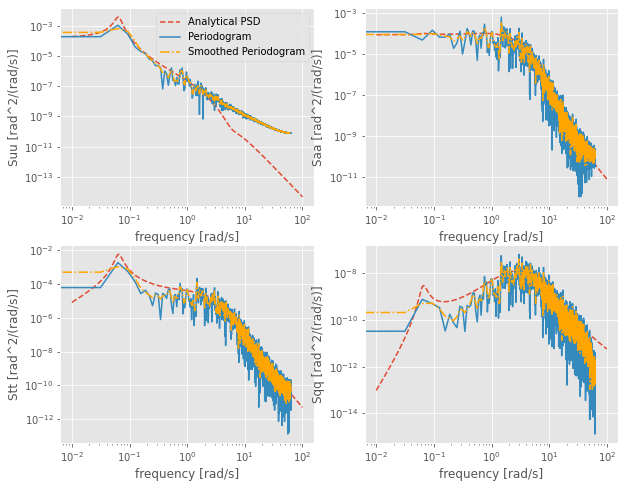

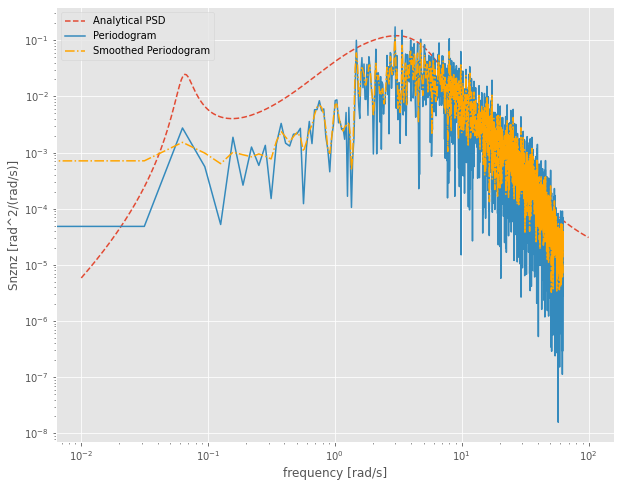

In [74]:


states = ['u', 'alpha', 'theta', 'q', 'nz']
S_names = ["Suu", "Saa", "Stt", "Sqq", "Snznz"]

plt.figure()
for i in range(len(states)-1):
    # loglog plot
    plt.subplot(2, 2, i+1)
    plt.loglog(w, Sxx[:, i], linestyle='--', label = 'Analytical PSD')
    plt.loglog(omega, P_lst[i][:round(N/2)], label = 'Periodogram')
    plt.loglog(omega, P_lst_new[i][:round(N/2)], label = 'Smoothed Periodogram', linestyle = '-.', color = 'orange')
    plt.xlabel('frequency [rad/s]')
    plt.ylabel(f'{S_names[i]} [rad^2/(rad/s)]')
    if i == 0:
        plt.legend()
    # make the plots bigger
    plt.gcf().set_size_inches(10, 8)
    # save the plot
plt.savefig(f'figures/PSDstates_vs_w.pdf')

# plot the PSD of nz vs omega (rad/s) with fancy colors
plt.figure()
plt.loglog(w, Sxx[:, -1], linestyle='--', label='Analytical PSD')
plt.loglog(omega, Pnz[:round(N/2)], label='Periodogram')
plt.loglog(omega, P_lst_new[-1][:round(N/2)], label='Smoothed Periodogram', linestyle='-.', color = 'orange')
plt.xlabel('frequency [rad/s]')
plt.ylabel('Snznz [rad^2/(rad/s)]')
plt.legend()
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
plt.savefig(f'figures/PSDnz_vs_w.pdf')

